In [1]:
%reload_ext autoreload
%autoreload 2

## Import packages

In [2]:
import sys

sys.path.append(r"D:\github\ripple_heterogeneity\python")
import functions, loading, add_new_deep_sup, pairwise_ccg_deep_sup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
import random


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


## default plotting

In [3]:
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

functions.set_plotting_defaults()

## get list of sessions and run analysis

In [31]:
basepath = 'Z:\Data\AYAold\AB1\day1'
states = "nrem"
# load data
st, cell_metrics, ripples, nrem_epochs, wake_epochs = pairwise_ccg_deep_sup.load_data(basepath)

if st is None:
    # return None
    pass
# restrict to state
if states is not None:
    if states == "nrem":
        st = st[nrem_epochs]
        ripples = ripples[nrem_epochs]
    elif states == "wake":
        st = st[wake_epochs]
        ripples = ripples[wake_epochs]
    else:
        raise ValueError("states must be 'nrem' or 'wake'")
    if (st is None) | len(ripples.starts) == 0:
        # return None
        pass

In [30]:
ripples

<EpochArray at 0x1aa86cd5220: 1,063 epochs> of length 56.908 seconds

In [32]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

not_to_use = (df["basepath"].str.contains("OMLproject", case=False)) | (
    df["basepath"].str.contains("ORproject", case=False)
)
df = df.loc[~not_to_use]

save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake"
pairwise_ccg_deep_sup.run(df,save_path,parallel=True,states="wake")

In [82]:
save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_wake"
# save_path = r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_counts_par"
ccgs, ccg_id_df = pairwise_ccg_deep_sup.load_results(save_path)


In [83]:
ccg_id_df['layer_label'] = 'unknown'

idx = (ccg_id_df.deepSuperficial_ref == 'Deep') & (ccg_id_df.deepSuperficial_target == 'Deep')
ccg_id_df.loc[idx,'layer_label'] = 'same_layer'
idx = (ccg_id_df.deepSuperficial_ref == 'Superficial') & (ccg_id_df.deepSuperficial_target == 'Superficial')
ccg_id_df.loc[idx,'layer_label'] = 'same_layer'

idx = (ccg_id_df.deepSuperficial_ref == 'Deep') & (ccg_id_df.deepSuperficial_target == 'Superficial')
ccg_id_df.loc[idx,'layer_label'] = 'cross_layer'
idx = (ccg_id_df.deepSuperficial_ref == 'Superficial') & (ccg_id_df.deepSuperficial_target == 'Deep')
ccg_id_df.loc[idx,'layer_label'] = 'cross_layer'

In [23]:
animal_id = [loading.get_animal_id(basepath) for basepath in ccg_id_df.basepath]
ccg_id_df['animal_id'] = animal_id

In [25]:
# ccg_id_df.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_ccg_deep_sup_using_counts_par_id_df.csv")

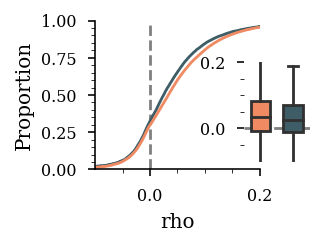

In [84]:
import custom_plots

group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}
sns.set_palette(sns.color_palette(group_colors.values()))


fig = plt.figure(figsize=functions.set_size('thesis', fraction=.25, subplots=(1.5, 1)), edgecolor='k')
axs = plt.gca()

box_ax = custom_plots.plot_ecdf_box(
    data=ccg_id_df,
    x="rho",
    hue="layer_label",
    hue_order=group_colors.keys(),
    x_offset=0.7,
    y_offset=0.04,
    showfliers=False,
    ax=axs,
    fig=fig)
axs.set_xlim(-0.1, .2)
box_ax.set_ylim(-0.1, .2)
axs.axvline(0, color='grey', linestyle='--',zorder=-100)
box_ax.axhline(0, color='grey', linestyle='--',zorder=-100)

# plt.savefig(os.path.join(fig_save_path,'pairwise_ripple_corr_deep_sup.svg'),dpi=300,bbox_inches='tight')


In [85]:
from scipy.stats import zscore

ccgs_z = zscore(ccgs, axis=0)


## plot results

<AxesSubplot:>

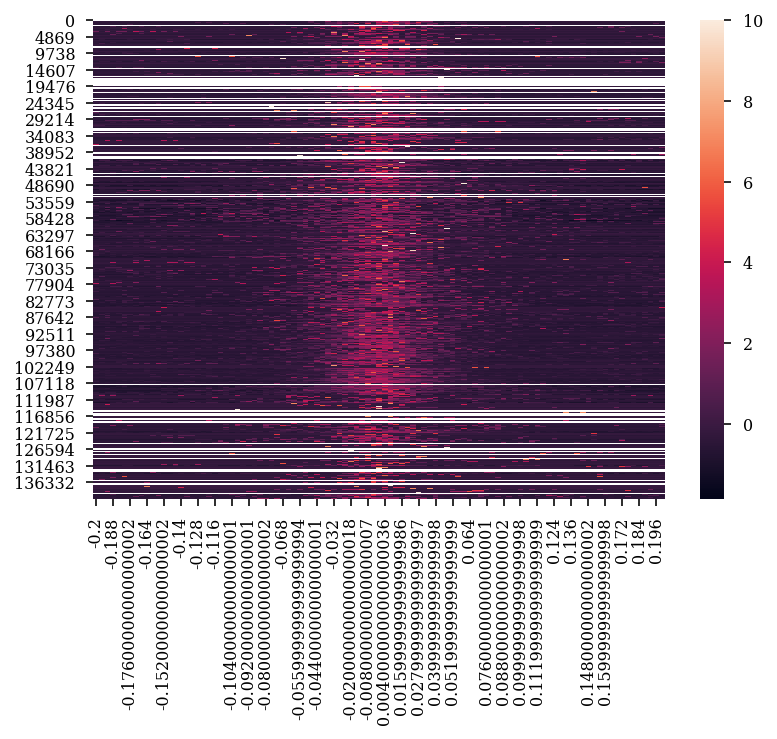

In [86]:
sns.heatmap(ccgs_z.T)


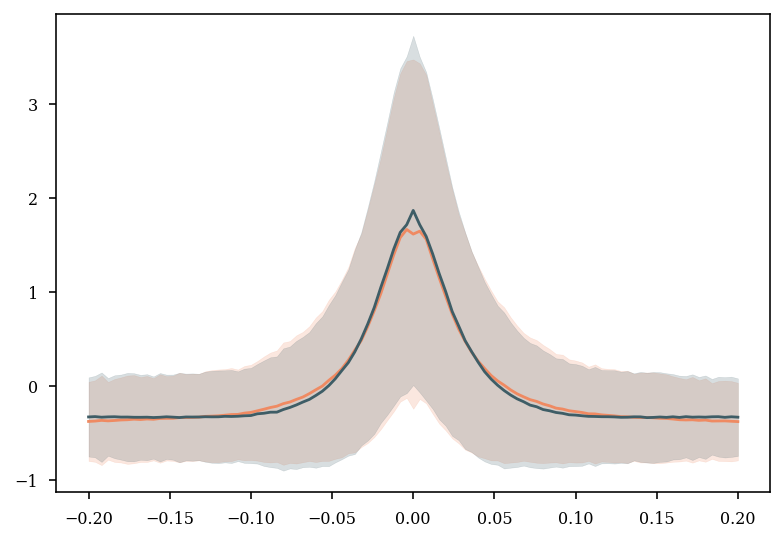

In [89]:
group_colors = {"same_layer": '#ef8a62',
            'cross_layer': '#3e5d66'}

idx = np.where(ccg_id_df.layer_label == "same_layer")[0]
y = np.nanmean(ccgs_z.iloc[:,idx],axis=1)
x = ccgs_z.index
std = np.nanstd(ccgs_z.iloc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['same_layer'],label='same layer')
plt.fill_between(x, y-std, y+std,color=group_colors['same_layer'] ,alpha=0.2)

idx = np.where(ccg_id_df.layer_label == "cross_layer")[0]
y = np.nanmean(ccgs_z.iloc[:,idx],axis=1)
x = ccgs_z.index
sem = np.nanstd(ccgs_z.iloc[:,idx],axis=1)
plt.plot(x,y,color=group_colors['cross_layer'],label='cross layer')
plt.fill_between(x, y-std, y+std,color=group_colors['cross_layer'] ,alpha=0.2)

plt.show()

In [62]:
idx

array([    23,     24,     25, ..., 142665, 142666, 142668], dtype=int64)

In [ ]:
idx = np.where(
    (ccg_id_df.deepSuperficial_ref == "Deep") & (ccg_id_df.deepSuperficial_target == "Deep")
)[0]
plt.plot(ccgs_z.iloc[:,idx])
plt.show()

idx = np.where(
    (ccg_id_df.deepSuperficial_ref == "Superficial")
    & (ccg_id_df.deepSuperficial_target == "Superficial")
)[0]
plt.plot(ccgs_z.iloc[:,idx])
plt.show()

idx = np.where(
    (ccg_id_df.deepSuperficial_ref == "Deep")
    & (ccg_id_df.deepSuperficial_target == "Superficial")
)[0]
plt.plot(ccgs_z.iloc[:,idx])
plt.show()
